In [2]:
# Install required packages
!pip install -q autoawq protobuf==3.20.0
!pip install -q datasets transformers pandas numpy tqdm requests matplotlib seaborn openai accelerate
!pip install -U bitsandbytes

# Import libraries
import os
import json
import time
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset
from tqdm import tqdm
from typing import Dict, List, Optional
from datetime import datetime
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from openai import OpenAI
import warnings
import bitsandbytes as bnb
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All packages installed and imported successfully!")


All packages installed and imported successfully!


In [3]:
import getpass
from openai import OpenAI
# Configuration
# import QwQ-32B model
MODEL_NAME = "Qwen/QwQ-32B-AWQ"
DATASET_NAME = "HuggingFaceH4/MATH-500"

# Get API token
if 'HF_TOKEN' not in os.environ:
    hf_token = getpass.getpass("Enter your Hugging Face API token: ")
    os.environ['HF_TOKEN'] = hf_token
else:
    hf_token = os.environ['HF_TOKEN']

# Verify token
if len(hf_token) < 10:
    print("Invalid token. Please check your Hugging Face token.")
else:
    print("API token configured successfully!")

# Initialize OpenAI client with HuggingFace router
client = OpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=os.environ["HF_TOKEN"],
)

print(f"\nConfiguration:")
print(f"Model: {MODEL_NAME}")
print(f"Dataset: {DATASET_NAME}")
print(f"API Base: https://router.huggingface.co/v1")

# VRAM check
print("Allocated (GB):", torch.cuda.memory_allocated() / 1e9)
print("Reserved  (GB):", torch.cuda.memory_reserved() / 1e9)

Enter your Hugging Face API token: ··········
API token configured successfully!

Configuration:
Model: Qwen/QwQ-32B-AWQ
Dataset: HuggingFaceH4/MATH-500
API Base: https://router.huggingface.co/v1
Allocated (GB): 0.0
Reserved  (GB): 0.0


In [6]:
# # Check if model is accessible

# Load model
print("⏳ Loading model...")


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True
)

model.eval()

print("✅ Model loaded successfully!")
print(f"Model device map -> {model.hf_device_map}")

# VRAM check
print("Allocated (GB):", torch.cuda.memory_allocated() / 1e9)
print("Reserved  (GB):", torch.cuda.memory_reserved() / 1e9)

⏳ Loading model...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

✅ Model loaded successfully!
Model device map -> {'': 0}
Allocated (GB): 19.396635136
Reserved  (GB): 19.480444928


Loading MATH-500 dataset...


README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset loaded successfully!
Total problems: 500
Columns: ['problem', 'solution', 'answer', 'subject', 'level', 'unique_id']

Dataset Overview:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,problem,solution,answer,subject,level,unique_id
0,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,We count the number of times $\frac{1}{n^3}$ a...,p - q,Intermediate Algebra,5,test/intermediate_algebra/1994.json



Subject Distribution:
subject
Algebra                   124
Intermediate Algebra       97
Prealgebra                 82
Number Theory              62
Precalculus                56
Geometry                   41
Counting & Probability     38
Name: count, dtype: int64

Difficulty Level Distribution:
level
1     43
2     90
3    105
4    128
5    134
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


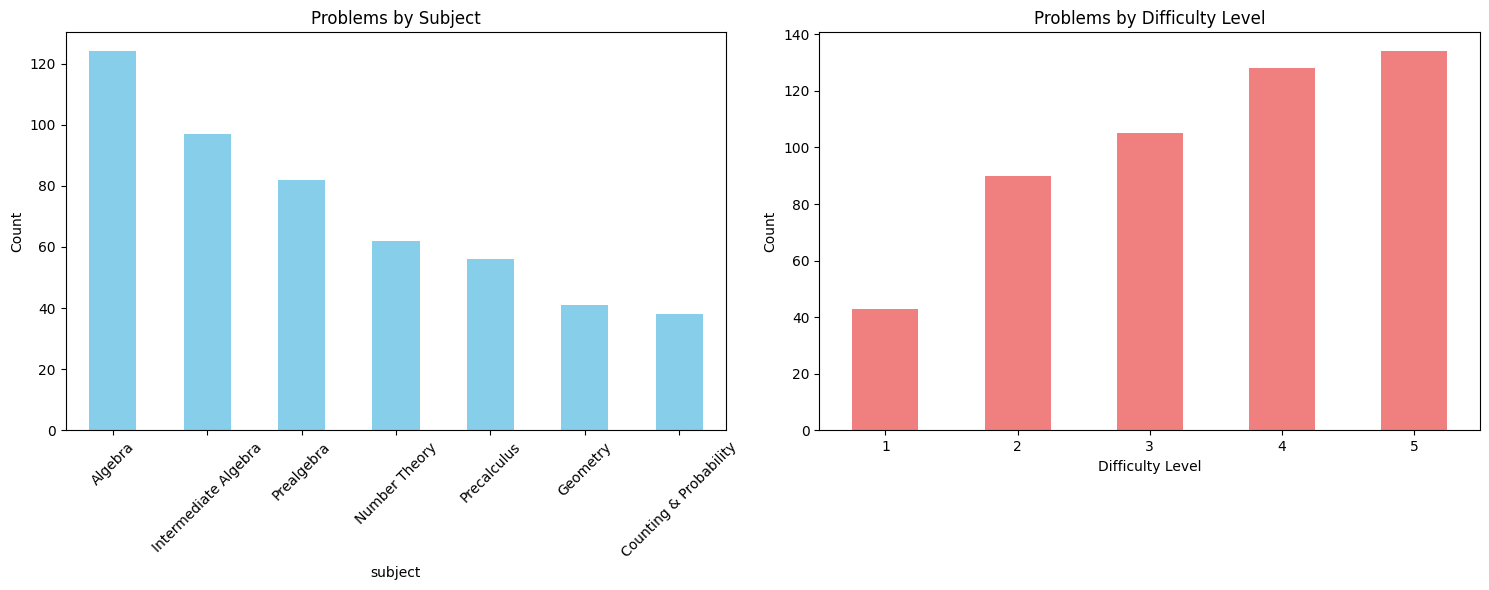

In [7]:
# Load the MATH-500 dataset
print("Loading MATH-500 dataset...")
dataset = load_dataset(DATASET_NAME)
df = dataset['test'].to_pandas()

print(f"Dataset loaded successfully!")
print(f"Total problems: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Display dataset structure
print("\nDataset Overview:")
display(df.head(2))

# Subject distribution
print("\nSubject Distribution:")
subject_counts = df['subject'].value_counts()
print(subject_counts)

# Difficulty level distribution
print("\nDifficulty Level Distribution:")
level_counts = df['level'].value_counts().sort_index()
print(level_counts)

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Subject distribution plot
subject_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Problems by Subject')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Level distribution plot
level_counts.plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Problems by Difficulty Level')
ax2.set_xlabel('Difficulty Level')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [8]:
# Display a sample problem
sample = df.iloc[0]
print("Sample Problem:")
print(f"Subject: {sample['subject']}")
print(f"Level: {sample['level']}")
print(f"\nProblem:\n{sample['problem']}")
print(f"\nExpected Answer: {sample['answer']}")

Sample Problem:
Subject: Precalculus
Level: 2

Problem:
Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \le \theta < 2 \pi.$

Expected Answer: \left( 3, \frac{\pi}{2} \right)


In [9]:
import re
import json
from datetime import datetime
from typing import Dict, List, Optional

import torch
import pandas as pd
from tqdm import tqdm

@torch.no_grad()
def generate_qwen_plain(
    model,
    tokenizer,
    prompt: str,
    max_new_tokens: int = 256,
    temperature: float = 0.0,
    top_p: float = 1.0,
) -> str:
    """
    Minimal generation helper for local Qwen2.5-32B-Instruct.
    IMPORTANT: Only uses tokenizer(...) — no tokenizer.chat anywhere.
    """
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=False,
        truncation=True,
    ).to(model.device)

    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=(temperature > 0),
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id,
    )

    # Decode ONLY the newly generated tokens
    new_tokens = output_ids[0, inputs["input_ids"].shape[-1]:]
    text = tokenizer.decode(new_tokens, skip_special_tokens=True)
    return text.strip()


class MathEvaluatorLocal:
    """
    Fresh evaluator that uses generate_qwen_plain().
    This avoids any previous MathEvaluator / generate_local_completion definitions.
    """

    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.results: List[Dict] = []

    @staticmethod
    def create_math_prompt(problem: str) -> str:
        return (
            "You are a helpful math expert. Solve the following problem step by step.\n"
            "At the very end, write the final answer in the form:\n"
            "`Final answer: <answer>`\n\n"
            f"Problem:\n{problem}\n\n"
            "Show your reasoning first, then provide `Final answer: <answer>`."
        )

    def call_model(self, problem: str) -> str:
        prompt = self.create_math_prompt(problem)
        return generate_qwen_plain(
            self.model,
            self.tokenizer,
            prompt,
            max_new_tokens=512,
            temperature=0.0,
            top_p=1.0,
        )

    @staticmethod
    def extract_final_answer(model_response: str) -> str:
        if not model_response:
            return "No response"

        pattern = r"final answer\s*[:\-]\s*(.*)"
        matches = re.findall(pattern, model_response, flags=re.IGNORECASE)

        if matches:
            candidate = matches[-1].strip()
            candidate = candidate.replace("`", "").strip()
            candidate = candidate.split("\n")[0].strip()
            return candidate

        boxed = re.findall(r"\\boxed\{([^}]*)\}", model_response)
        if boxed:
            return boxed[-1].strip()

        last_line = model_response.strip().split("\n")[-1]
        return last_line.strip()

    @staticmethod
    def normalize_answer(ans: str) -> str:
        if ans is None:
            return ""
        ans = ans.strip()
        ans = ans.replace("\\(", "").replace("\\)", "").replace("$", "")
        ans = ans.replace("\\left", "").replace("\\right", "")
        ans = ans.replace("\\cdot", "*")
        ans = ans.replace("\\,", "").replace("\\ ", "")
        ans = ans.lower()
        ans = re.sub(r"[^a-z0-9\.\+\-\*\/\(\)]", "", ans)
        return ans

    def is_answer_correct(self, extracted: str, expected: str) -> bool:
        if not extracted or not expected:
            return False
        e_norm = self.normalize_answer(extracted)
        gt_norm = self.normalize_answer(expected)
        return e_norm == gt_norm

    def evaluate_problem(self, problem_data: Dict, idx: int) -> Dict:
        problem = problem_data["problem"]
        expected = problem_data["answer"]
        subject = problem_data.get("subject", "")
        level = problem_data.get("level", "")
        unique_id = problem_data.get("unique_id", "")

        try:
            model_response = self.call_model(problem)
        except Exception as e:
            model_response = f"Error: {e}"

        extracted_answer = self.extract_final_answer(model_response)
        correct = self.is_answer_correct(extracted_answer, expected)

        return {
            "problem_index": idx,
            "unique_id": unique_id,
            "subject": subject,
            "level": level,
            "problem": problem,
            "expected_answer": expected,
            "model_response": model_response,
            "extracted_answer": extracted_answer,
            "correct": correct,
            "response_length": len(model_response),
        }

    def evaluate_dataset(
        self,
        df: pd.DataFrame,
        limit: Optional[int] = None,
        progress_bar: bool = True,
    ) -> Dict:
        n = len(df) if limit is None else min(limit, len(df))
        print(f"🚀 Evaluating {n} problems with local Qwen2.5-32B-Instruct (4-bit)...")

        start_time = datetime.now()
        results: List[Dict] = []

        iterator = range(n)
        if progress_bar:
            iterator = tqdm(iterator)

        for i in iterator:
            row = df.iloc[i].to_dict()
            res = self.evaluate_problem(row, i)
            results.append(res)

        total_time = (datetime.now() - start_time).total_seconds()
        summary = self.generate_summary(results, total_time)
        self.results = results
        return {"results": results, "summary": summary}

    @staticmethod
    def generate_summary(results: List[Dict], total_time: float) -> Dict:
        if not results:
            return {"error": "No results"}

        df_res = pd.DataFrame(results)
        total = len(df_res)
        correct = df_res["correct"].sum()
        overall_acc = correct / total if total > 0 else 0.0

        subject_stats = (
            df_res.groupby("subject")["correct"]
            .agg(["count", "sum", "mean"])
            .rename(columns={"count": "num_problems", "num_correct": "sum", "accuracy": "mean"})
        )

        level_stats = (
            df_res.groupby("level")["correct"]
            .agg(["count", "sum", "mean"])
            .rename(columns={"count": "num_problems", "num_correct": "sum", "accuracy": "mean"})
        )

        avg_len = df_res["response_length"].mean()

        return {
            "model_name": "Qwen2.5-32B-Instruct (local 4-bit)",
            "timestamp": datetime.now().isoformat(),
            "total_problems": int(total),
            "num_correct": int(correct),
            "overall_accuracy": float(overall_acc),
            "total_time_seconds": float(total_time),
            "problems_per_minute": float(total / (total_time / 60)) if total_time > 0 else 0.0,
            "avg_response_length": float(avg_len),
        }

print("✅ MathEvaluatorLocal and generate_qwen_plain defined.")


✅ MathEvaluatorLocal and generate_qwen_plain defined.


In [10]:
import contextlib

@torch.no_grad()
def generate_qwen_batch(
    model,
    tokenizer,
    prompts: List[str],
    max_new_tokens: int = 256,
    temperature: float = 0.0,
    top_p: float = 1.0,
) -> List[str]:
    """
    Batched generation for a list of prompts.
    Returns a list of decoded strings, one per prompt.
    """
    device = next(model.parameters()).device

    enc = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    # Length of each prompt before padding
    input_lengths = (input_ids != tokenizer.pad_token_id).sum(dim=1)

    output_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=(temperature > 0),
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id,
    )

    responses = []
    for i in range(output_ids.size(0)):
        new_tokens = output_ids[i, input_lengths[i] : ]
        text = tokenizer.decode(new_tokens, skip_special_tokens=True)
        responses.append(text.strip())

    return responses


def evaluate_dataset_batched(
    evaluator: MathEvaluatorLocal,
    df: pd.DataFrame,
    limit: Optional[int] = None,
    batch_size: int = 8,
    progress_bar: bool = True,
) -> Dict:
    """
    Faster evaluation by batching problems on the GPU.
    Uses evaluator's extract_final_answer + is_answer_correct.
    """
    model = evaluator.model
    tokenizer = evaluator.tokenizer

    n = len(df) if limit is None else min(limit, len(df))
    df_eval = df.iloc[:n].reset_index(drop=True)

    print(f"🚀 Batched evaluation of {n} problems (batch_size={batch_size})...")

    start_time = datetime.now()
    results: List[Dict] = []

    indices = range(0, n, batch_size)
    if progress_bar:
        indices = tqdm(indices)

    for start in indices:
        end = min(start + batch_size, n)
        batch_rows = df_eval.iloc[start:end]
        problems = batch_rows["problem"].tolist()

        # Build prompts
        prompts = [evaluator.create_math_prompt(p) for p in problems]

        # Batched generation
        raw_responses = generate_qwen_batch(
            model,
            tokenizer,
            prompts,
            max_new_tokens=512,
            temperature=0.0,
            top_p=1.0,
        )

        # Per-example post-processing
        for i, (idx, row) in enumerate(batch_rows.iterrows()):
            problem = row["problem"]
            expected = row["answer"]
            subject = row.get("subject", "")
            level = row.get("level", "")
            unique_id = row.get("unique_id", "")

            model_response = raw_responses[i]
            extracted_answer = evaluator.extract_final_answer(model_response)
            correct = evaluator.is_answer_correct(extracted_answer, expected)

            results.append(
                {
                    "problem_index": idx,
                    "unique_id": unique_id,
                    "subject": subject,
                    "level": level,
                    "problem": problem,
                    "expected_answer": expected,
                    "model_response": model_response,
                    "extracted_answer": extracted_answer,
                    "correct": correct,
                    "response_length": len(model_response),
                }
            )

    total_time = (datetime.now() - start_time).total_seconds()

    # Reuse evaluator's summary logic
    summary = MathEvaluatorLocal.generate_summary(results, total_time)

    return {"results": results, "summary": summary}

In [11]:

print("Testing local model with MathEvaluatorLocal...")

evaluator = MathEvaluatorLocal(model, tokenizer)

test_problem = "What is 2 + 2?"
print(f"Test problem: {test_problem}\n")

response = evaluator.call_model(test_problem)
print("Raw model response:\n")
print(response)
print("\n------------------------------")

extracted = evaluator.extract_final_answer(response)
print(f"Extracted final answer: {extracted}")



The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Testing local model with MathEvaluatorLocal...
Test problem: What is 2 + 2?

Raw model response:

Step 1: Start by looking at the problem: 2 + 2. 

Step 2: Remember that addition is the process of combining two numbers to find their total. 

Step 3: The first number is 2, and the second number is also 2. 

Step 4: Adding them together: 2 plus 2. 

Step 5: Recall that 2 + 2 equals 4. 

Step 6: Confirm the result by counting: starting at 2, adding 2 more brings you to 4. 

Step 7: Verify with a number line: moving two units from 2 lands on 4. 

Step 8: All methods confirm the sum is 4. 

Final answer: 4

Wait, hold on. Let me check again. Maybe I made a mistake. Let me count on my fingers. If I hold up two fingers on one hand and two on the other, that's four total. Yeah, that's right. So the answer is definitely 4. I think that's correct. Hmm, maybe I should use another method. Let's think in terms of objects. If I have two apples and someone gives me two more, I have four apples. Yep, 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [12]:
from contextlib import contextmanager
from typing import List, Dict, Optional
import torch
from torch import nn, Tensor
from tqdm import tqdm

@contextmanager
def add_hooks(module_forward_pre_hooks=None, module_forward_hooks=None):
    module_forward_pre_hooks = module_forward_pre_hooks or []
    module_forward_hooks = module_forward_hooks or []

    handles = []
    for module, hook in module_forward_pre_hooks:
        handles.append(module.register_forward_pre_hook(hook))
    for module, hook in module_forward_hooks:
        handles.append(module.register_forward_hook(hook))

    try:
        yield
    finally:
        for h in handles:
            h.remove()


def get_block_modules_qwen(model: nn.Module) -> List[nn.Module]:
    return list(model.model.layers)


def tokenize_instructions_local(
    tokenizer,
    instructions: List[str],
    max_length: int = 256,
):
    return tokenizer(
        instructions,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
    )


def get_mean_activations_pre_hook(
    layer_idx: int,
    cache: Tensor,          # [n_positions, n_layers, d_model] on CPU
    n_samples: int,
    positions: List[int],
):
    """
    Accumulate mean residual activations at given positions for a layer.
    cache is on CPU, activations are copied per batch from GPU.
    """

    def hook_fn(module, inputs):
        x: Tensor = inputs[0]  # [batch, seq, d_model] on GPU
        # select positions and move to CPU float32
        selected_cpu = x[:, positions, :].detach().to("cpu", dtype=torch.float32)  # [batch, n_pos, d_model]
        # sum over batch and accumulate
        cache[:, layer_idx] += (1.0 / n_samples) * selected_cpu.sum(dim=0)
        return inputs

    return hook_fn


def get_mean_activations_local(
    model: nn.Module,
    tokenizer,
    instructions: List[str],
    block_modules: List[nn.Module],
    batch_size: int = 2,
    positions: Optional[List[int]] = None,
    max_length: int = 256,
) -> Tensor:
    """
    Compute mean residual-stream activations, caching on CPU to save VRAM.
    Returns: [n_positions, n_layers, d_model] (on CPU, float32)
    """
    if positions is None:
        positions = [-1]  # last token

    torch.cuda.empty_cache()

    n_positions = len(positions)
    n_layers = model.config.num_hidden_layers
    n_samples = len(instructions)
    d_model = model.config.hidden_size

    # ⭐ cache on CPU in float32, not GPU float64
    mean_activations = torch.zeros(
        (n_positions, n_layers, d_model),
        dtype=torch.float32,
        device="cpu",
    )

    fwd_pre_hooks = [
        (
            block_modules[layer_idx],
            get_mean_activations_pre_hook(
                layer_idx=layer_idx,
                cache=mean_activations,
                n_samples=n_samples,
                positions=positions,
            ),
        )
        for layer_idx in range(n_layers)
    ]

    device = next(model.parameters()).device

    with torch.no_grad():
        for i in tqdm(range(0, len(instructions), batch_size), desc="Mean activations"):
            batch = instructions[i : i + batch_size]
            inputs = tokenize_instructions_local(tokenizer, batch, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with add_hooks(module_forward_pre_hooks=fwd_pre_hooks, module_forward_hooks=[]):
                _ = model(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                )

            # free as much as we can each loop
            del inputs
            torch.cuda.empty_cache()

    return mean_activations


In [13]:
# Rebuild math_instructions fresh so all activation code can use it

# Number of problems to use for activation experiments
N = 16  # adjust as needed

subset_df = df.head(N).copy()

math_instructions = []

for _, row in subset_df.iterrows():
    prompt = (
        "You are a helpful math expert. Solve the following problem step by step.\n"
        "At the very end, write the final answer in the form:\n"
        "`Final answer: <answer>`\n\n"
        f"Problem:\n{row['problem']}\n\n"
        "Show your reasoning first, then provide `Final answer: <answer>`."
    )
    math_instructions.append(prompt)

print(f"Prepared {len(math_instructions)} math instructions.")
print("Example:\n")
print(math_instructions[0])


Prepared 16 math instructions.
Example:

You are a helpful math expert. Solve the following problem step by step.
At the very end, write the final answer in the form:
`Final answer: <answer>`

Problem:
Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \le \theta < 2 \pi.$

Show your reasoning first, then provide `Final answer: <answer>`.


In [14]:
# Test mean activations on MATH prompts

block_modules = get_block_modules_qwen(model)

positions = [-1]  # last token
mean_acts = get_mean_activations_local(
    model,
    tokenizer,
    math_instructions,   # N=16 from above
    block_modules,
    batch_size=1,        # very safe
    positions=positions,
    max_length=256,
)

print("Mean activations shape:", mean_acts.shape)
print("Mean activations device:", mean_acts.device)



Mean activations:  31%|███▏      | 5/16 [00:02<00:05,  1.96it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Mean activations: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

Mean activations shape: torch.Size([1, 64, 5120])
Mean activations device: cpu


In [15]:
from typing import Dict

def _activation_cache_hook_factory(layer_idx: int, cache: Dict[int, List[Tensor]]):
    def hook_fn(module, inputs):
        x: Tensor = inputs[0]        # [batch, seq, d_model] on device
        x_cpu = x.detach().to("cpu")
        for sample in x_cpu:        # [seq, d_model]
            cache[layer_idx].append(sample.clone())
        return inputs
    return hook_fn


def cache_activations_for_instructions_local(
    model: nn.Module,
    tokenizer,
    instructions: List[str],
    layers: Optional[List[int]] = None,
    batch_size: int = 2,
    max_length: int = 256,
) -> Dict[int, List[Tensor]]:
    block_modules = get_block_modules_qwen(model)
    n_layers = model.config.num_hidden_layers
    if layers is None:
        layers = list(range(n_layers))

    activations_cache: Dict[int, List[Tensor]] = {l: [] for l in layers}

    fwd_pre_hooks = [
        (block_modules[layer_idx], _activation_cache_hook_factory(layer_idx, activations_cache))
        for layer_idx in layers
    ]

    device = next(model.parameters()).device
    torch.cuda.empty_cache()

    with torch.no_grad():
        for i in tqdm(range(0, len(instructions), batch_size), desc="Caching activations"):
            batch = instructions[i : i + batch_size]
            inputs = tokenize_instructions_local(tokenizer, batch, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with add_hooks(module_forward_pre_hooks=fwd_pre_hooks, module_forward_hooks=[]):
                _ = model(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                )

            del inputs
            torch.cuda.empty_cache()

    return activations_cache

print("Caching utilities defined.")


Caching utilities defined.


In [ ]:
K = 8
test_instructions = math_instructions[:K]
layers_to_cache = [0, model.config.num_hidden_layers - 1]

activ_cache = cache_activations_for_instructions_local(
    model,
    tokenizer,
    test_instructions,
    layers=layers_to_cache,
    batch_size=2,
    max_length=256,
)

for l in layers_to_cache:
    print(f"Layer {l}: cached {len(activ_cache[l])} sequences")
    print("  Shape of first cached:", activ_cache[l][0].shape)  # [seq_len, d_model]


Caching activations: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

Layer 0: cached 8 sequences
  Shape of first cached: torch.Size([164, 3584])
Layer 27: cached 8 sequences
  Shape of first cached: torch.Size([164, 3584])


In [17]:
def _normalize_direction(direction: Tensor) -> Tensor:
    return direction / (direction.norm(dim=-1, keepdim=False) + 1e-12)


def _direction_intervention_pre_hook_factory(
    layer_idx: int,
    direction: Tensor,                 # [d_model]
    mode: str = "addition",            # "addition" or "ablation"
    positions: Optional[List[int]] = None,
    alpha: float = 1.0,
):
    """
    Direction-based intervention hook:

    - "addition": x' = x + alpha * d_hat
    - "ablation": x' = x - (x·d_hat) d_hat   (directional ablation)
    """
    # Keep a CPU copy normalized; move to device inside the hook
    dir_unit_cpu = _normalize_direction(direction).to(torch.float32)

    def hook_fn(module, inputs):
        x: Tensor = inputs[0]  # [batch, seq, d_model] on GPU or CPU
        batch, seq, d_model = x.shape

        # 🔑 Move direction to the same device/dtype as x
        dir_unit = dir_unit_cpu.to(x.device, dtype=x.dtype)

        # Build position mask on the same device
        if positions is None:
            mask = torch.ones((batch, seq, 1), device=x.device, dtype=x.dtype)
        else:
            mask = torch.zeros((batch, seq, 1), device=x.device, dtype=x.dtype)
            for pos in positions:
                mask[:, pos, :] = 1.0

        if mode == "addition":
            x_mod = x + alpha * mask * dir_unit.view(1, 1, -1)
        elif mode == "ablation":
            proj = (x * dir_unit.view(1, 1, -1)).sum(dim=-1, keepdim=True)
            x_mod = x - mask * proj * dir_unit.view(1, 1, -1)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        return (x_mod,) + inputs[1:]

    return hook_fn


def build_direction_intervention_hooks_local(
    model: nn.Module,
    directions: Tensor,      # [n_positions, n_layers, d_model]
    position_index: int = 0,
    mode: str = "addition",
    alpha: float = 1.0,
    positions: Optional[List[int]] = None,
) -> List:
    block_modules = get_block_modules_qwen(model)
    n_positions, n_layers, d_model = directions.shape

    assert n_layers == model.config.num_hidden_layers
    assert d_model == model.config.hidden_size

    if not (0 <= position_index < n_positions):
        raise IndexError(f"position_index {position_index} out of range for n_positions={n_positions}")

    hooks = []
    layer_dirs: Tensor = directions[position_index]  # [n_layers, d_model]

    for layer_idx in range(n_layers):
        layer_dir = layer_dirs[layer_idx]
        hook_fn = _direction_intervention_pre_hook_factory(
            layer_idx=layer_idx,
            direction=layer_dir,
            mode=mode,
            positions=positions,
            alpha=alpha,
        )
        hooks.append((block_modules[layer_idx], hook_fn))

    return hooks

print("Direction intervention utilities defined.")


Direction intervention utilities defined.


In [18]:
# Use mean_acts computed earlier: shape [1, n_layers, d_model]
direction_tensor = mean_acts.to(torch.float32)

# Build hooks: add direction at last token with some strength
hooks = build_direction_intervention_hooks_local(
    model,
    directions=direction_tensor,
    position_index=0,     # since positions=[-1] when we computed mean_acts
    mode="addition",      # or "ablation"
    alpha=0.5,
    positions=[-1],       # apply at last token
)

print(f"Built {len(hooks)} intervention hooks.")

# Pick one MATH problem
row0 = df.iloc[0]
test_problem = row0["problem"]

print("\n=== Baseline (no intervention) ===\n")
baseline_resp = generate_qwen_plain(
    model,
    tokenizer,
    MathEvaluatorLocal.create_math_prompt(test_problem),
    max_new_tokens=256,
    temperature=0.0,
)
print(baseline_resp[:800], "...\n")

print("=== With direction intervention ===\n")
prompt = MathEvaluatorLocal.create_math_prompt(test_problem)

with add_hooks(module_forward_pre_hooks=hooks, module_forward_hooks=[]):
    intervened_resp = generate_qwen_plain(
        model,
        tokenizer,
        prompt,
        max_new_tokens=256,
        temperature=0.0,
    )

print(intervened_resp[:800], "...")


Built 64 intervention hooks.

=== Baseline (no intervention) ===

Alright, so I need to convert the rectangular coordinates (0, 3) to polar coordinates. Hmm, okay. Let me recall how polar coordinates work. Polar coordinates are represented as (r, θ), where r is the distance from the origin to the point, and θ is the angle made with the positive x-axis. 

First, I should find the value of r. The formula for r in terms of rectangular coordinates (x, y) is r = √(x² + y²). Let me plug in the values here. The point given is (0, 3), so x is 0 and y is 3. 

Calculating r: 
r = √(0² + 3²) = √(0 + 9) = √9 = 3. Okay, so that part is straightforward. The radius r is 3. 

Now, the angle θ is a bit trickier. The formula for θ is usually θ = arctan(y/x), but I have to be careful because when x is 0, this formula might not work directly. Let me think. In this case, x i ...

=== With direction intervention ===

Alright, so I need to convert the rectangular coordinates (0, 3) to polar coordinates. Hmm,

In [19]:
evaluator = MathEvaluatorLocal(model, tokenizer)

BATCH_SIZE = 8  # tune based on VRAM (8–16 usually works)

# Use the full dataset
NUM_PROBLEMS = len(df)  # all problems in your DataFrame

out = evaluate_dataset_batched(
    evaluator,
    df,
    limit=NUM_PROBLEMS,      # or just remove this argument
    batch_size=BATCH_SIZE,
    progress_bar=True,
)

summary = out["summary"]
print("\n📊 Batched accuracy on MATH-500")
print(f"Problems:   {summary['total_problems']}")
print(f"Correct:    {summary['num_correct']}")
print(f"Accuracy:   {summary['overall_accuracy'] * 100:.2f}%")
print(f"Time (s):   {summary['total_time_seconds']:.2f}")
print(f"Prob/min:   {summary['problems_per_minute']:.2f}")

results_df = pd.DataFrame(out["results"])


🚀 Batched evaluation of 500 problems (batch_size=8)...


  2%|▏         | 1/63 [01:21<1:23:57, 81.26s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
  2%|▏         | 1/63 [02:20<2:25:41, 140.99s/it]


KeyboardInterrupt: 

In [26]:
from collections import defaultdict

def attach_activation_hooks(model, layers_to_hook=None):
    """
    layers_to_hook: list of layer indices or None to hook all layers
    """
    cache = defaultdict(list)
    handles = []

    if layers_to_hook is None:
        layers_to_hook = range(len(model.model.layers))

    for idx in layers_to_hook:
        layer = model.model.layers[idx]

        def make_hook(i):
            def hook_fn(module, input, output):
                # Move to CPU only after the forward pass to avoid Triton errors
                cache[f"layer_{i}"].append(output.detach().cpu())
            return hook_fn

        h = layer.register_forward_hook(make_hook(idx))
        handles.append(h)

    return cache, handles


In [27]:
text = "what is 4+4"
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(model.device)

cache, handles = attach_activation_hooks(model)   # hook all layers

with torch.no_grad():
    _ = model(input_ids)

# Remove hooks
for h in handles:
    h.remove()

# Inspect activations
for k, v in cache.items():
    print(k, v[0].shape)


layer_0 torch.Size([1, 6, 5120])
layer_1 torch.Size([1, 6, 5120])
layer_2 torch.Size([1, 6, 5120])
layer_3 torch.Size([1, 6, 5120])
layer_4 torch.Size([1, 6, 5120])
layer_5 torch.Size([1, 6, 5120])
layer_6 torch.Size([1, 6, 5120])
layer_7 torch.Size([1, 6, 5120])
layer_8 torch.Size([1, 6, 5120])
layer_9 torch.Size([1, 6, 5120])
layer_10 torch.Size([1, 6, 5120])
layer_11 torch.Size([1, 6, 5120])
layer_12 torch.Size([1, 6, 5120])
layer_13 torch.Size([1, 6, 5120])
layer_14 torch.Size([1, 6, 5120])
layer_15 torch.Size([1, 6, 5120])
layer_16 torch.Size([1, 6, 5120])
layer_17 torch.Size([1, 6, 5120])
layer_18 torch.Size([1, 6, 5120])
layer_19 torch.Size([1, 6, 5120])
layer_20 torch.Size([1, 6, 5120])
layer_21 torch.Size([1, 6, 5120])
layer_22 torch.Size([1, 6, 5120])
layer_23 torch.Size([1, 6, 5120])
layer_24 torch.Size([1, 6, 5120])
layer_25 torch.Size([1, 6, 5120])
layer_26 torch.Size([1, 6, 5120])
layer_27 torch.Size([1, 6, 5120])
layer_28 torch.Size([1, 6, 5120])
layer_29 torch.Size([1, 

In [28]:
def attach_qkv_hooks(model):
    cache = defaultdict(list)
    handles = []

    for i, layer in enumerate(model.model.layers):

        # Q projection
        def make_hook(name):
            return lambda m, inp, out: cache[name].append(out.detach().cpu())

        h1 = layer.self_attention.q_proj.register_forward_hook(
            make_hook(f"layer_{i}_q")
        )
        h2 = layer.self_attention.k_proj.register_forward_hook(
            make_hook(f"layer_{i}_k")
        )
        h3 = layer.self_attention.v_proj.register_forward_hook(
            make_hook(f"layer_{i}_v")
        )

        handles.extend([h1, h2, h3])

    return cache, handles


In [29]:
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ActivationVisualizer:
    def __init__(self, model):
        self.model = model
        self.cache = defaultdict(list)
        self.handles = []

    def _make_hook(self, name):
        def hook_fn(module, inputs, output):
            # Convert to CPU only after computation to avoid Triton errors
            act = output.detach().float().cpu()
            self.cache[name].append(act)
        return hook_fn

    def hook_layers(self, names_dict):
        """
        names_dict = { "name": module_or_list_of_modules }
        Example:
            {
              "L12_resid": model.model.layers[12],
              "L12_q": model.model.layers[12].self_attention.q_proj
            }
        """
        for name, module in names_dict.items():
            if isinstance(module, (list, tuple)):
                for i, m in enumerate(module):
                    h = m.register_forward_hook(self._make_hook(f"{name}_{i}"))
                    self.handles.append(h)
            else:
                h = module.register_forward_hook(self._make_hook(name))
                self.handles.append(h)

    def remove_hooks(self):
        for h in self.handles:
            h.remove()
        self.handles = []

    def clear(self):
        self.cache.clear()

    def plot(self, key, token_idx=None, head_idx=None, figsize=(8, 4)):
        """
        Visualize one activation:
        - token_idx: plot activations for a single token
        - head_idx: for Q/K/V of shape [batch, seq, heads, dim]
        """
        acts = self.cache[key][0]  # first forward pass
        arr = acts.numpy()

        # Handle Q/K/V case: [B, S, H, D]
        if arr.ndim == 4 and head_idx is not None:
            arr = arr[0, :, head_idx, :]  # (S, D)

        # Handle hidden states: [B, S, D]
        elif arr.ndim == 3 and token_idx is not None:
            arr = arr[0, token_idx, :][None, :]  # (1, D)

        # Default: if 3D, flatten batch
        elif arr.ndim == 3:
            arr = arr[0]  # (S, D)

        plt.figure(figsize=figsize)
        plt.imshow(arr, aspect='auto', interpolation='nearest')
        plt.colorbar()
        plt.title(f"Activation: {key}")
        plt.xlabel("Feature dimension")
        plt.ylabel("Token index")
        plt.show()


In [22]:
layer_id = 12
layer = model.model.layers[layer_id]

for name, module in layer.named_modules():
    print(name, "→", type(module))


 → <class 'transformers.models.qwen2.modeling_qwen2.Qwen2DecoderLayer'>
self_attn → <class 'transformers.models.qwen2.modeling_qwen2.Qwen2Attention'>
self_attn.q_proj → <class 'awq.modules.linear.gemm.WQLinear_GEMM'>
self_attn.k_proj → <class 'awq.modules.linear.gemm.WQLinear_GEMM'>
self_attn.v_proj → <class 'awq.modules.linear.gemm.WQLinear_GEMM'>
self_attn.o_proj → <class 'awq.modules.linear.gemm.WQLinear_GEMM'>
mlp → <class 'transformers.models.qwen2.modeling_qwen2.Qwen2MLP'>
mlp.gate_proj → <class 'awq.modules.linear.gemm.WQLinear_GEMM'>
mlp.up_proj → <class 'awq.modules.linear.gemm.WQLinear_GEMM'>
mlp.down_proj → <class 'awq.modules.linear.gemm.WQLinear_GEMM'>
mlp.act_fn → <class 'transformers.activations.SiLUActivation'>
input_layernorm → <class 'transformers.models.qwen2.modeling_qwen2.Qwen2RMSNorm'>
post_attention_layernorm → <class 'transformers.models.qwen2.modeling_qwen2.Qwen2RMSNorm'>


In [30]:
layer_id = 12
layer = model.model.layers[layer_id]

viz = ActivationVisualizer(model)

viz.hook_layers({
    # Layer output (residual stream)
    "resid12": layer,

    # Attention projections
    "q12": layer.self_attn.q_proj,
    "k12": layer.self_attn.k_proj,
    "v12": layer.self_attn.v_proj,
    "o12": layer.self_attn.o_proj,

    # MLP projections
    "mlp_gate12": layer.mlp.gate_proj,
    "mlp_up12": layer.mlp.up_proj,
    "mlp_down12": layer.mlp.down_proj,

    # Norms (optional but useful)
    "ln_in12": layer.input_layernorm,
    "ln_post12": layer.post_attention_layernorm,
})


In [32]:
text = "four plus four is"
tokens = tokenizer(text, return_tensors="pt").to(model.device)

with torch.no_grad():
    _ = model(**tokens)


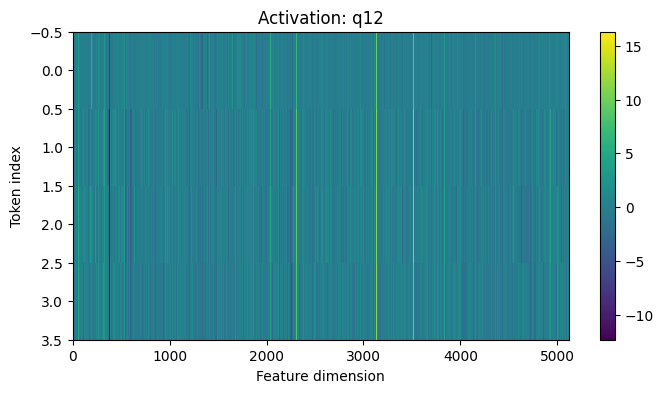

In [33]:
import matplotlib.pyplot as plt

viz.plot("q12")

